# estimate $p(M_*, M_h | {\rm mags})$ using NPE for central subhalos
using forward modeled photometry constructed from TNG subhalos

In [1]:
import os, h5py
import numpy as np
from astropy import table as aTable
from tqdm.notebook import tqdm, trange

In [2]:
import torch 
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
# -- plotting -- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read in central galaxies train/test datasets at $z=0.1$

In [4]:
subhalo_train = aTable.Table.read('/Users/chahah/data/frb_halos/subhalos.central.snapshot91.train.csv')
subhalo_test = aTable.Table.read('/Users/chahah/data/frb_halos/subhalos.central.snapshot91.test.csv')

In [5]:
subhalo_train[:5]

g_Sersic_Reff,g_Sersic_mag,g_CAS_C,g_CAS_A,snapshot,subhalo_id,version,i_Sersic_Reff,i_Sersic_mag,i_CAS_C,i_CAS_A,r_Sersic_Reff,r_Sersic_mag,r_CAS_C,r_CAS_A,y_Sersic_Reff,y_Sersic_mag,y_CAS_C,y_CAS_A,z_Sersic_Reff,z_Sersic_mag,z_CAS_C,z_CAS_A,SubhaloMassType_stars,SubhaloMassType_dm
float64,float64,float64,float64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
16.5282,13.4244,5.23794,0.0904381,91,0,v2,14.4653,12.0606,5.30594,0.0861324,13.0986,12.6109,5.41252,0.0893994,13.5889,11.6764,5.30594,0.0698951,14.0126,11.7837,5.30594,0.0778021,12.7342,14.2415
17.0677,13.4204,5.43369,0.128438,91,0,v3,11.8979,12.1546,5.59752,0.151465,19.8217,12.3975,5.43369,0.135967,11.0848,11.7779,5.49236,0.135583,13.2725,11.8089,5.59752,0.1419,12.7342,14.2415
17.1306,13.4667,5.69275,0.103165,91,0,v1,16.8541,12.0389,5.69275,0.129235,16.8944,12.5384,5.5885,0.106361,17.1656,11.6107,5.64329,0.0945187,16.6774,11.7437,5.74775,0.119082,12.7342,14.2415
17.353,13.4715,5.49236,0.0655124,91,0,v0,15.1905,12.1003,5.66127,0.0809164,17.953,12.5103,5.32853,0.0727035,18.0359,11.6035,5.38695,0.0659247,14.8276,11.8243,5.66127,0.0771571,12.7342,14.2415
8.35147,14.3709,3.76913,0.156349,91,70250,v0,4.53571,13.381,4.1056,0.119823,5.2346,13.7961,4.22041,0.132992,4.3566,12.9982,3.98999,0.0989417,4.71578,13.0893,3.98999,0.10153,12.1915,13.8559


## set up train/test dataset
Our photometric observables are 
- `Sersic_mag` 
for the g, i, r, y, z bands

In [6]:
cols = []
for b in ['g', 'r', 'i', 'y', 'z']: 
    for p in ['Sersic_mag']: 
        cols.append('%s_%s' % (b, p))

In [7]:
y_test = np.array([np.array(subhalo_test[col].data) for col in ['SubhaloMassType_stars', 'SubhaloMassType_dm']]).T
x_test = np.array([np.array(subhalo_test[col].data) for col in cols]).T

y_train = np.array([np.array(subhalo_train[col].data) for col in ['SubhaloMassType_stars', 'SubhaloMassType_dm']]).T
x_train = np.array([np.array(subhalo_train[col].data) for col in cols]).T

(9.0, 15.0)

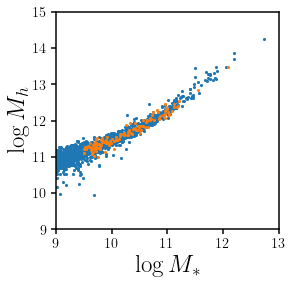

In [8]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)
sub.scatter(y_train[:,0], y_train[:,1], s=2)
sub.scatter(y_test[:,0], y_test[:,1], s=2)

sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9., 13)
sub.set_ylabel(r'$\log M_h$', fontsize=25)
sub.set_ylim(9., 15.)

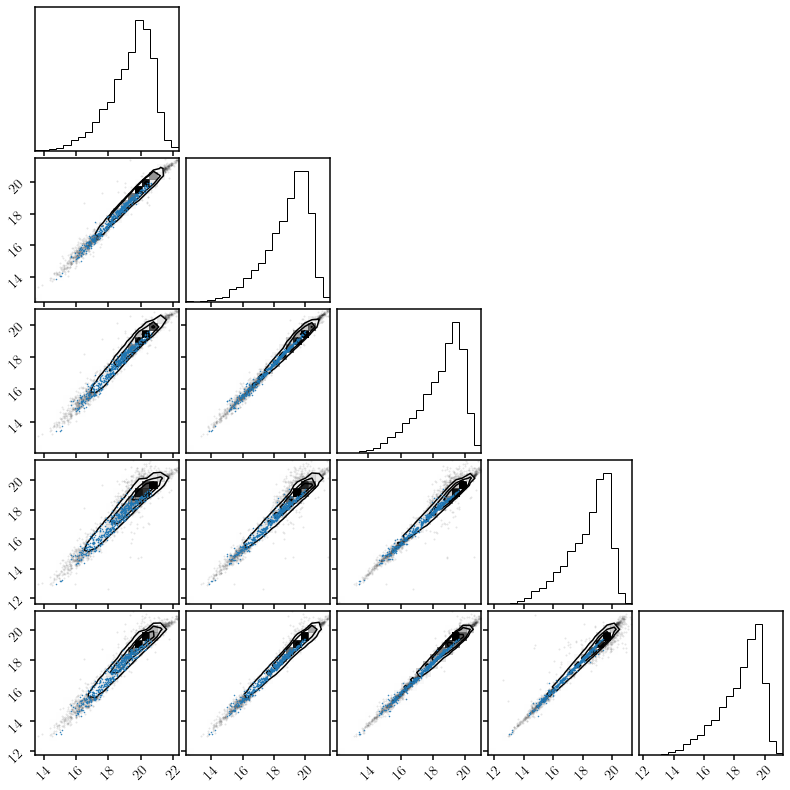

In [9]:
fig = DFM.corner(x_train)
DFM.overplot_points(fig, x_test, markersize=1)

# train NPE
We use a Masked Autoregressive Flow. We train 3 NPEs with random architectures with a 90/10 training/validation split and pick the NPE with the best validation loss. 

In [10]:
lower_bounds = torch.tensor([9., 9.]) # training set only includes galaxies with logMstar/Mun > 9
upper_bounds = torch.tensor([14., 15.])

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

In [11]:
fnpe = '/Users/chahah/data/frb_halos/npe_magonly.pt'

# train multiple NPEs and pick the best one
anpes, phats = [], []
valid_logprobs, best_valid_logprobs = [], []
archs = []
for i in range(10):
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(128)))))
    nblocks = int(np.random.uniform(3, 10))
    print('\n MAF with nhidden=%i; nblocks=%i' % (nhidden, nblocks))
    archs.append('%ix%i' % (nhidden, nblocks))

    anpe = Inference.SNPE(prior=prior,
                          density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
                          device='cpu')
    anpe.append_simulations(
        torch.as_tensor(y_train.astype(np.float32)),
        torch.as_tensor(x_train.astype(np.float32)))

    _phat = anpe.train()

    p_y_x_est = anpe.build_posterior(_phat)

    anpes.append(anpe)
    phats.append(p_y_x_est)

    valid_logprobs.append(anpe._summary['validation_log_probs'])
    best_valid_logprobs.append(anpe._summary['best_validation_log_probs'])

ibest = np.argmax(best_valid_logprobs)
best_anpe = anpes[ibest]
best_phat = phats[ibest]
best_arch = archs[ibest]

torch.save(best_phat, fnpe)


 MAF with nhidden=105; nblocks=7
 Neural network successfully converged after 115 epochs.
 MAF with nhidden=79; nblocks=4
 Neural network successfully converged after 140 epochs.
 MAF with nhidden=69; nblocks=6
 Neural network successfully converged after 186 epochs.
 MAF with nhidden=83; nblocks=3
 Neural network successfully converged after 86 epochs.
 MAF with nhidden=82; nblocks=7
 Neural network successfully converged after 163 epochs.
 MAF with nhidden=117; nblocks=3
 Neural network successfully converged after 40 epochs.
 MAF with nhidden=76; nblocks=3
 Neural network successfully converged after 38 epochs.
 MAF with nhidden=104; nblocks=3
 Neural network successfully converged after 111 epochs.
 MAF with nhidden=68; nblocks=6
 Neural network successfully converged after 101 epochs.
 MAF with nhidden=120; nblocks=8
 Neural network successfully converged after 71 epochs.

Text(0, 0.5, '-log validation likelihood')

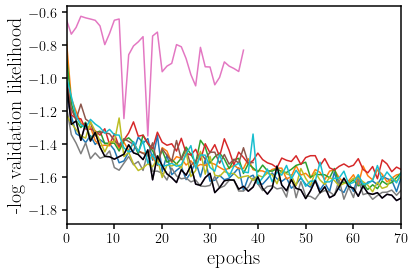

In [12]:
for vl in valid_logprobs: 
    plt.plot(-np.array(vl))
    plt.xlim(0., 70)
plt.plot(-np.array(valid_logprobs[ibest]), c='k')
plt.xlabel('epochs', fontsize=20)
plt.ylabel('-log validation likelihood', fontsize=20)

# validate NPE on test set

First lets examine the NPE posteriors for a handful of galaxies

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[11.0782 12.2699]
sigma_logM* = 0.1890
sigma_logMh = 0.1974


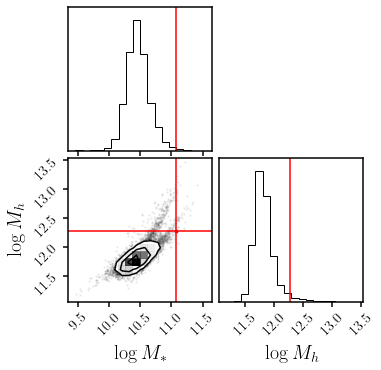

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.8398 11.4443]
sigma_logM* = 0.0907
sigma_logMh = 0.1019


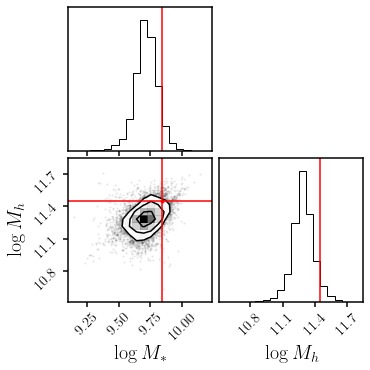

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.90878 11.4129 ]
sigma_logM* = 0.1051
sigma_logMh = 0.1069


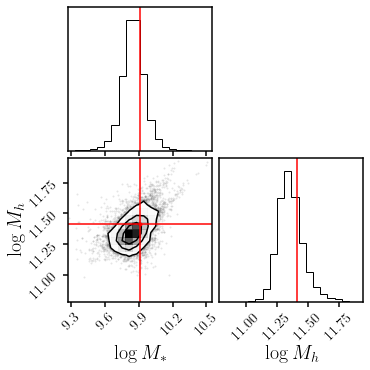

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[11.0184 12.1945]
sigma_logM* = 0.2960
sigma_logMh = 0.4269


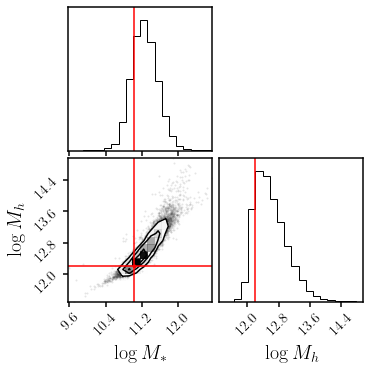

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[10.2937 11.6817]
sigma_logM* = 0.1106
sigma_logMh = 0.1302


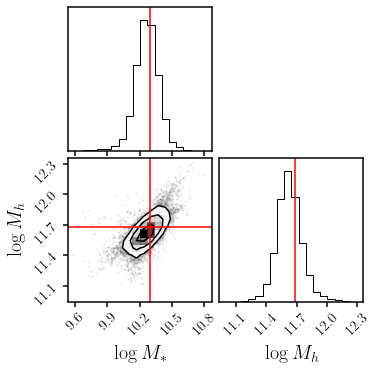

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.91903 11.5628 ]
sigma_logM* = 0.0967
sigma_logMh = 0.1136


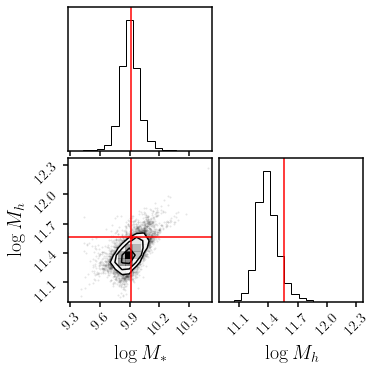

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[10.2127 11.6674]
sigma_logM* = 0.2901
sigma_logMh = 0.2303


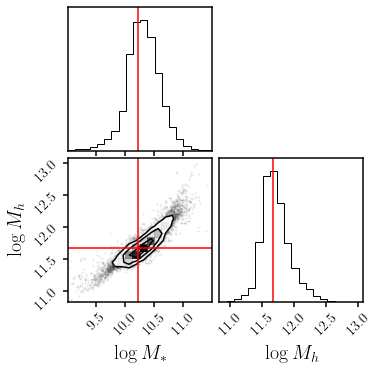

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.99172 11.3827 ]
sigma_logM* = 0.1030
sigma_logMh = 0.1172


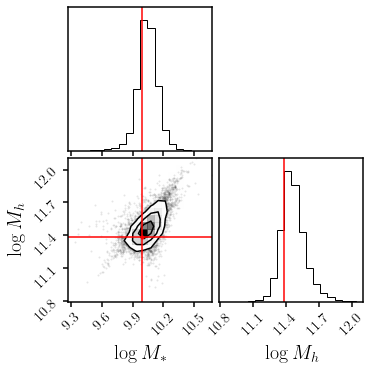

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.95444 11.3631 ]
sigma_logM* = 0.0938
sigma_logMh = 0.1125


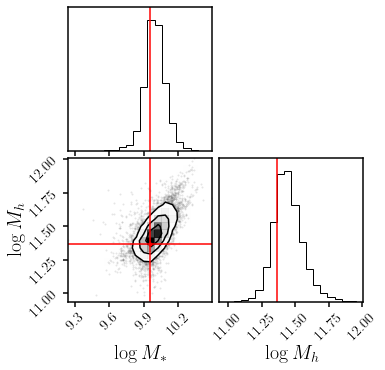

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.72277 11.2395 ]
sigma_logM* = 0.0924
sigma_logMh = 0.1005


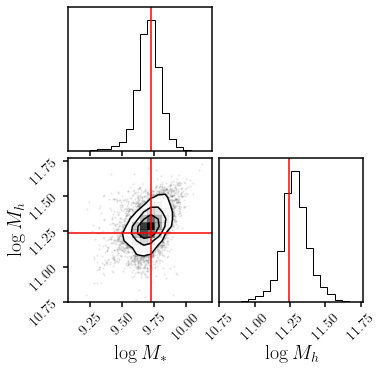

In [13]:
for i in np.random.choice(np.arange(x_test.shape[0]), size=10, replace=False): 
    _x, _y = x_test[i], y_test[i]

    # sample posterior p(theta | x)
    mcmc_npe = best_phat.sample((10000,),
            x=torch.as_tensor(_x.astype(np.float32)).to('cpu'),
            show_progress_bars=True)
    mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))
    
    print(_y)
    print('sigma_logM* = %.4f' % np.std(mcmc_npe, axis=0)[0])
    print('sigma_logMh = %.4f' % np.std(mcmc_npe, axis=0)[1])

    fig = DFM.corner(mcmc_npe, 
                     labels=[r'$\log M_*$', r'$\log M_h$'], 
                     label_kwargs={'fontsize': 20})
    DFM.overplot_points(fig, [_y], color='r')
    DFM.overplot_lines(fig, _y, color='r')
    plt.show()

now lets quantitatively validate the quality of the NPE posteriors using Simulation-Based Calibration (Talts et al. 2020)

In [14]:
ranks_logms, sigma_logms = [], [] 
ranks_logmh, sigma_logmh = [], [] 
for _x, _y in zip(x_test, y_test): 
    if _y[0] > 12: continue
    # sample posterior p(theta | x)
    mcmc_npe = best_phat.sample((10000,),
            x=torch.as_tensor(_x.astype(np.float32)).to('cpu'),
            show_progress_bars=False)
    mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))
    
    ranks_logms.append(np.sum(mcmc_npe[:,0] < _y[0]))
    sigma_logms.append(np.std(mcmc_npe, axis=0)[0])
    
    ranks_logmh.append(np.sum(mcmc_npe[:,1] < _y[1]))
    sigma_logmh.append(np.std(mcmc_npe, axis=0)[1])

(0.0, 2.0)

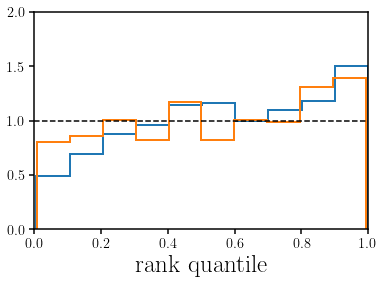

In [15]:
fig = plt.figure(figsize=(6, 4))
sub = fig.add_subplot(111)
_ = sub.hist(np.array(ranks_logms)/10000., density=True, histtype='step', linewidth=2)
_ = sub.hist(np.array(ranks_logmh)/10000., density=True, histtype='step', linewidth=2)
sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.set_xlabel('rank quantile', fontsize=25)
sub.set_xlim(0, 1.)
sub.set_ylim(0., 2.)

Not bad. NPEs infer more or less unbiased posteriors on $\log M_*$ and $\log M_h$. 

## check precision of posteriors

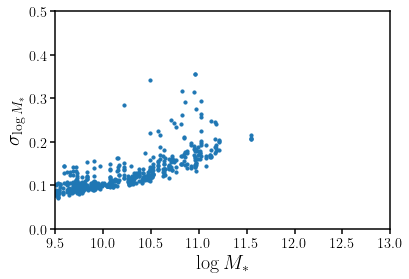

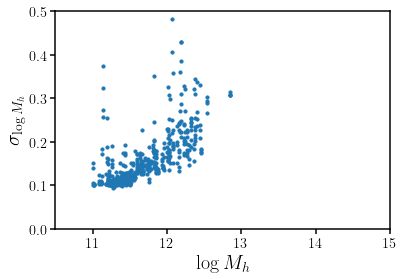

In [16]:
plt.scatter(y_test[:,0][y_test[:,0] <= 12.], sigma_logms, s=10)
plt.xlabel(r'$\log M_*$', fontsize=20)
plt.xlim(9.5, 13.)
plt.ylabel(r'$\sigma_{\log M_*}$', fontsize=20)
plt.ylim(0., 0.5)
plt.show()

plt.scatter(y_test[:,1][y_test[:,0] <= 12.], sigma_logmh, s=10)
plt.xlabel(r'$\log M_h$', fontsize=20)
plt.xlim(10.5, 15.)
plt.ylabel(r'$\sigma_{\log M_h}$', fontsize=20)
plt.ylim(0., 0.5)
plt.show()

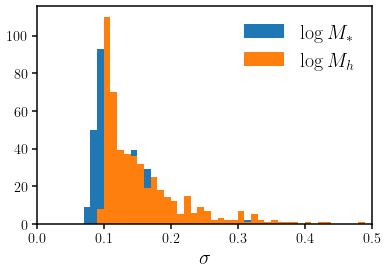

In [17]:
plt.hist(sigma_logms, range=(0., 1.), bins=100, label=r'$\log M_*$')
plt.hist(sigma_logmh, range=(0., 1.), bins=100, label=r'$\log M_h$')
#plt.vlines(0.1, 0., 70, color='k', linestyle='--')
plt.xlabel(r'$\sigma$', fontsize=20)
plt.xlim(0., 0.5)
plt.legend(loc='upper right', fontsize=20)

In [18]:
np.median(sigma_logms), np.median(sigma_logmh)

(0.11423887, 0.13428092)